# Automated Analysis of Indoor Climbing Walls Using Computer Vision

## Introduction

The analysis of indoor climbing routes is crucial for understanding route-setting patterns, evaluating difficulty levels, and assisting both climbers and gym operators in route optimization. Traditional methods of route evaluation rely on manual inspection, which is time-consuming and subjective. This study explores an automated approach leveraging computer vision techniques to analyze climbing wall images, focusing on detecting and classifying climbing holds based on their shapes and colors.

## Problem

The main challenge in analyzing climbing wall images lies in the accurate identification of holds while minimizing noise from the background and chalk marks. Additionally, climbing routes are typically defined by color-coded holds, needing color detection methods which have to account for varying lighting conditions. This study aims to develop a preprocessing pipeline for hold detection through noise reduction, edge detection, and color segmentation.

## Methodology

To process climbing wall images, we implemented a multi-step preprocessing pipeline:

1. **Grayscale Conversion:** The input images are converted to grayscale to focus on intensity values, reducing computational complexity.
2. **Edge Detection:** Various edge detection techniques, including Canny, Sobel, and Laplacian, were applied to identify hold boundaries.
3. **Noise Reduction:** A combination of Gaussian blur and median filtering was used to smooth the image while preserving hold edges.
4. **Chalk Removal:** Holds are often obscured by white chalk marks, which introduce false edges. To mitigate this, we employed HSV-based color thresholding followed by inpainting to reconstruct the original hold surfaces.
5. **Color-Based Route Identification:** Climbing routes are determined by hold colors, requiring segmentation techniques such as HSV color filtering and k-means clustering for improved color consistency across varying lighting conditions.
6. **Blob Detection:** Hold locations were identified using contour detection and SimpleBlobDetector, ensuring that valid holds were recognized based on their size and shape.

## Results

The preprocessing pipeline significantly improved hold visibility and edge detection accuracy. The combined Gaussian and median filter approach effectively reduced noise while preserving key features. Chalk removal through inpainting led to cleaner edge maps, minimizing false detections. Route classification based on color segmentation led to better results, though challenges remained in distinguishing holds of similar hues.

Further improvements were achieved by integrating a deep learning model (YOLOv8) for hold detection, which enhanced accuracy compared to traditional edge detection methods. Additionally, a fine-tuned Vision Transformer (ViT) multi-label classification model was implemented to classify holds by color, further improving route identification.

## Conclusion

This study demonstrates the potential of computer vision for automated climbing route analysis. The combination of traditional preprocessing techniques and deep learning models offers a scalable and efficient solution for hold detection and route classification. Future work will focus on refining lighting-invariant color classification techniques and integrating depth estimation to improve hold segmentation in three-dimensional space.



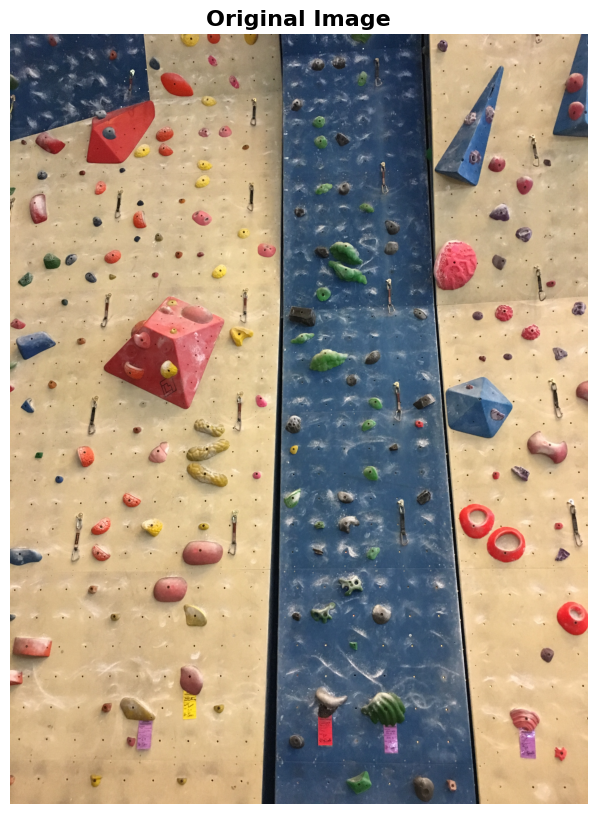

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Read the image
img_path = 'immagini test/IMG_001.JPG'
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 

# Display the image
plt.figure(figsize=(15,10))
plt.imshow(img)
plt.axis('off')
plt.title('Original Image', fontsize=16, fontweight='bold')
plt.show()

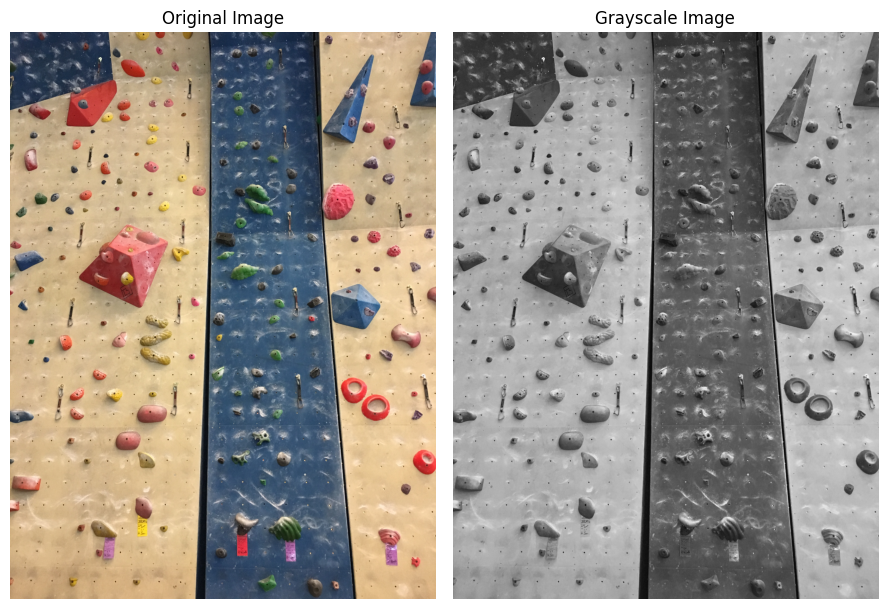

In [3]:
# Convert to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Display original and grayscale images side by side
plt.figure(figsize=(9, 6))

plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(img)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Grayscale Image')
plt.imshow(gray, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()

In [4]:
# Function to process edges for visualization: finds contours and draws them on a black background with thicker lines for better visibility
def process_edges_for_visualization(edges, thickness=3):    
    # Find contours in the edge image
    contours, _ = cv2.findContours(edges, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    
    # Create a black background image
    processed_image = np.zeros_like(edges)

    # Draw the contours in white with slightly thicker lines for better visibility
    processed_image = cv2.drawContours(processed_image, contours, -1, (255), thickness=thickness)
    
    return processed_image

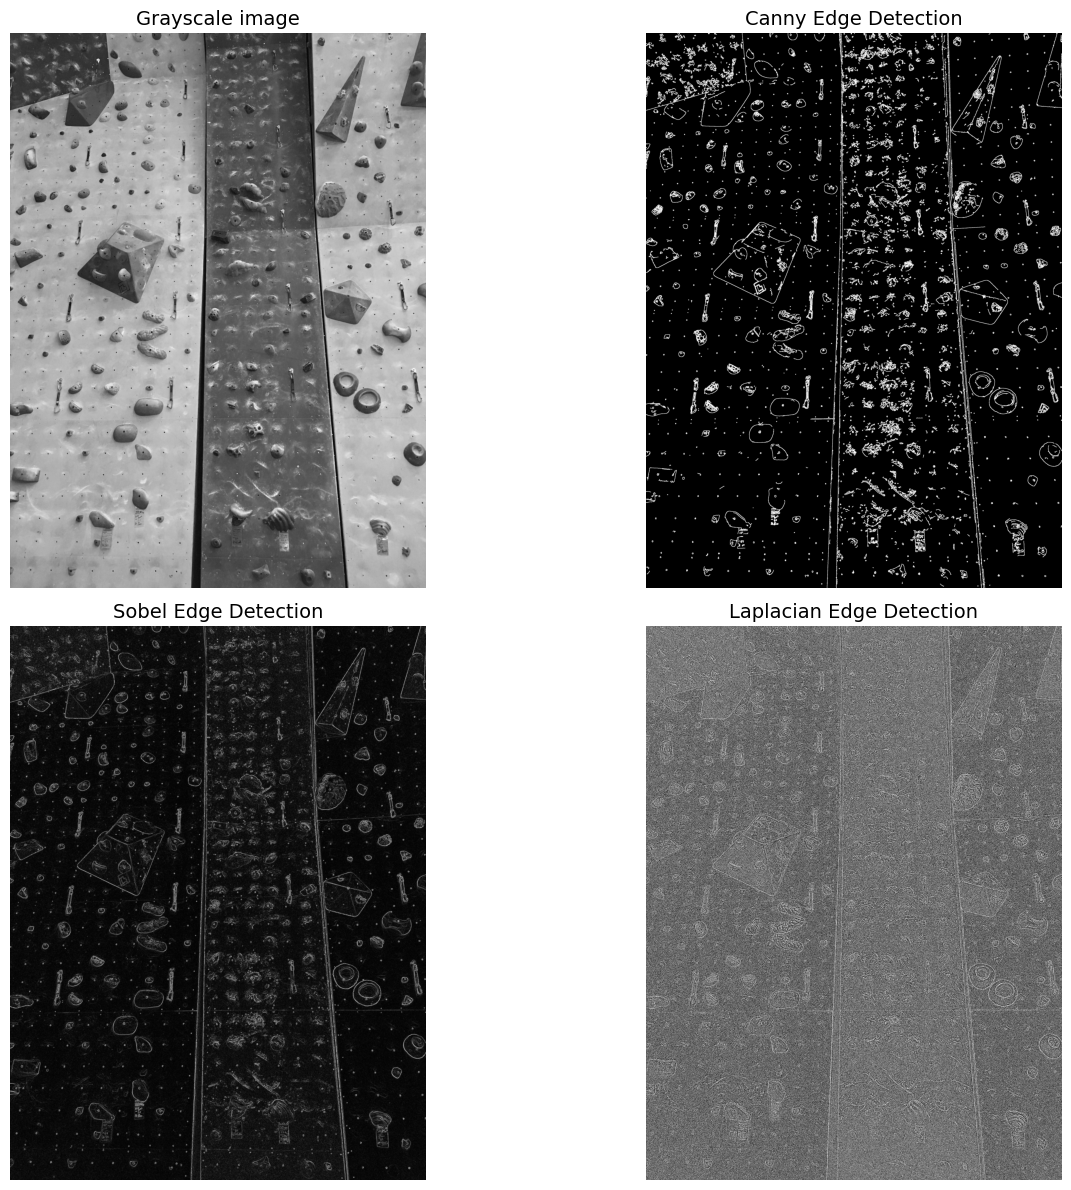

In [5]:
# Edge Detection Analysis
def detect_edges(image, method='canny', **kwargs):
    if method == 'canny':
        threshold1 = kwargs.get('threshold1', 100)
        threshold2 = kwargs.get('threshold2', 200)
        return cv2.Canny(image, threshold1, threshold2)
    elif method == 'sobel':
        sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
        sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
        return np.uint8(np.sqrt(sobelx**2 + sobely**2))
    elif method == 'laplacian':
        return cv2.Laplacian(image, cv2.CV_64F).astype(np.uint8)

# Apply different edge detection methods
canny_edges = process_edges_for_visualization(detect_edges(gray, 'canny', threshold1=50, threshold2=150), thickness=2)
sobel_edges = detect_edges(gray, 'sobel')
laplacian_edges = detect_edges(gray, 'laplacian')

plt.figure(figsize=(15, 12))

# Original grayscale
plt.subplot(2, 2, 1)
plt.title('Grayscale image', fontsize=14)
plt.imshow(gray, cmap='gray')
plt.axis('off')

# Canny edges
plt.subplot(2, 2, 2)
plt.title('Canny Edge Detection', fontsize=14)
plt.imshow(canny_edges, cmap='gray')
plt.axis('off')

# Sobel edges
plt.subplot(2, 2, 3)
plt.title('Sobel Edge Detection', fontsize=14)
plt.imshow(sobel_edges, cmap='gray')
plt.axis('off')

# Laplacian edges
plt.subplot(2, 2, 4)
plt.title('Laplacian Edge Detection', fontsize=14)
plt.imshow(laplacian_edges, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()

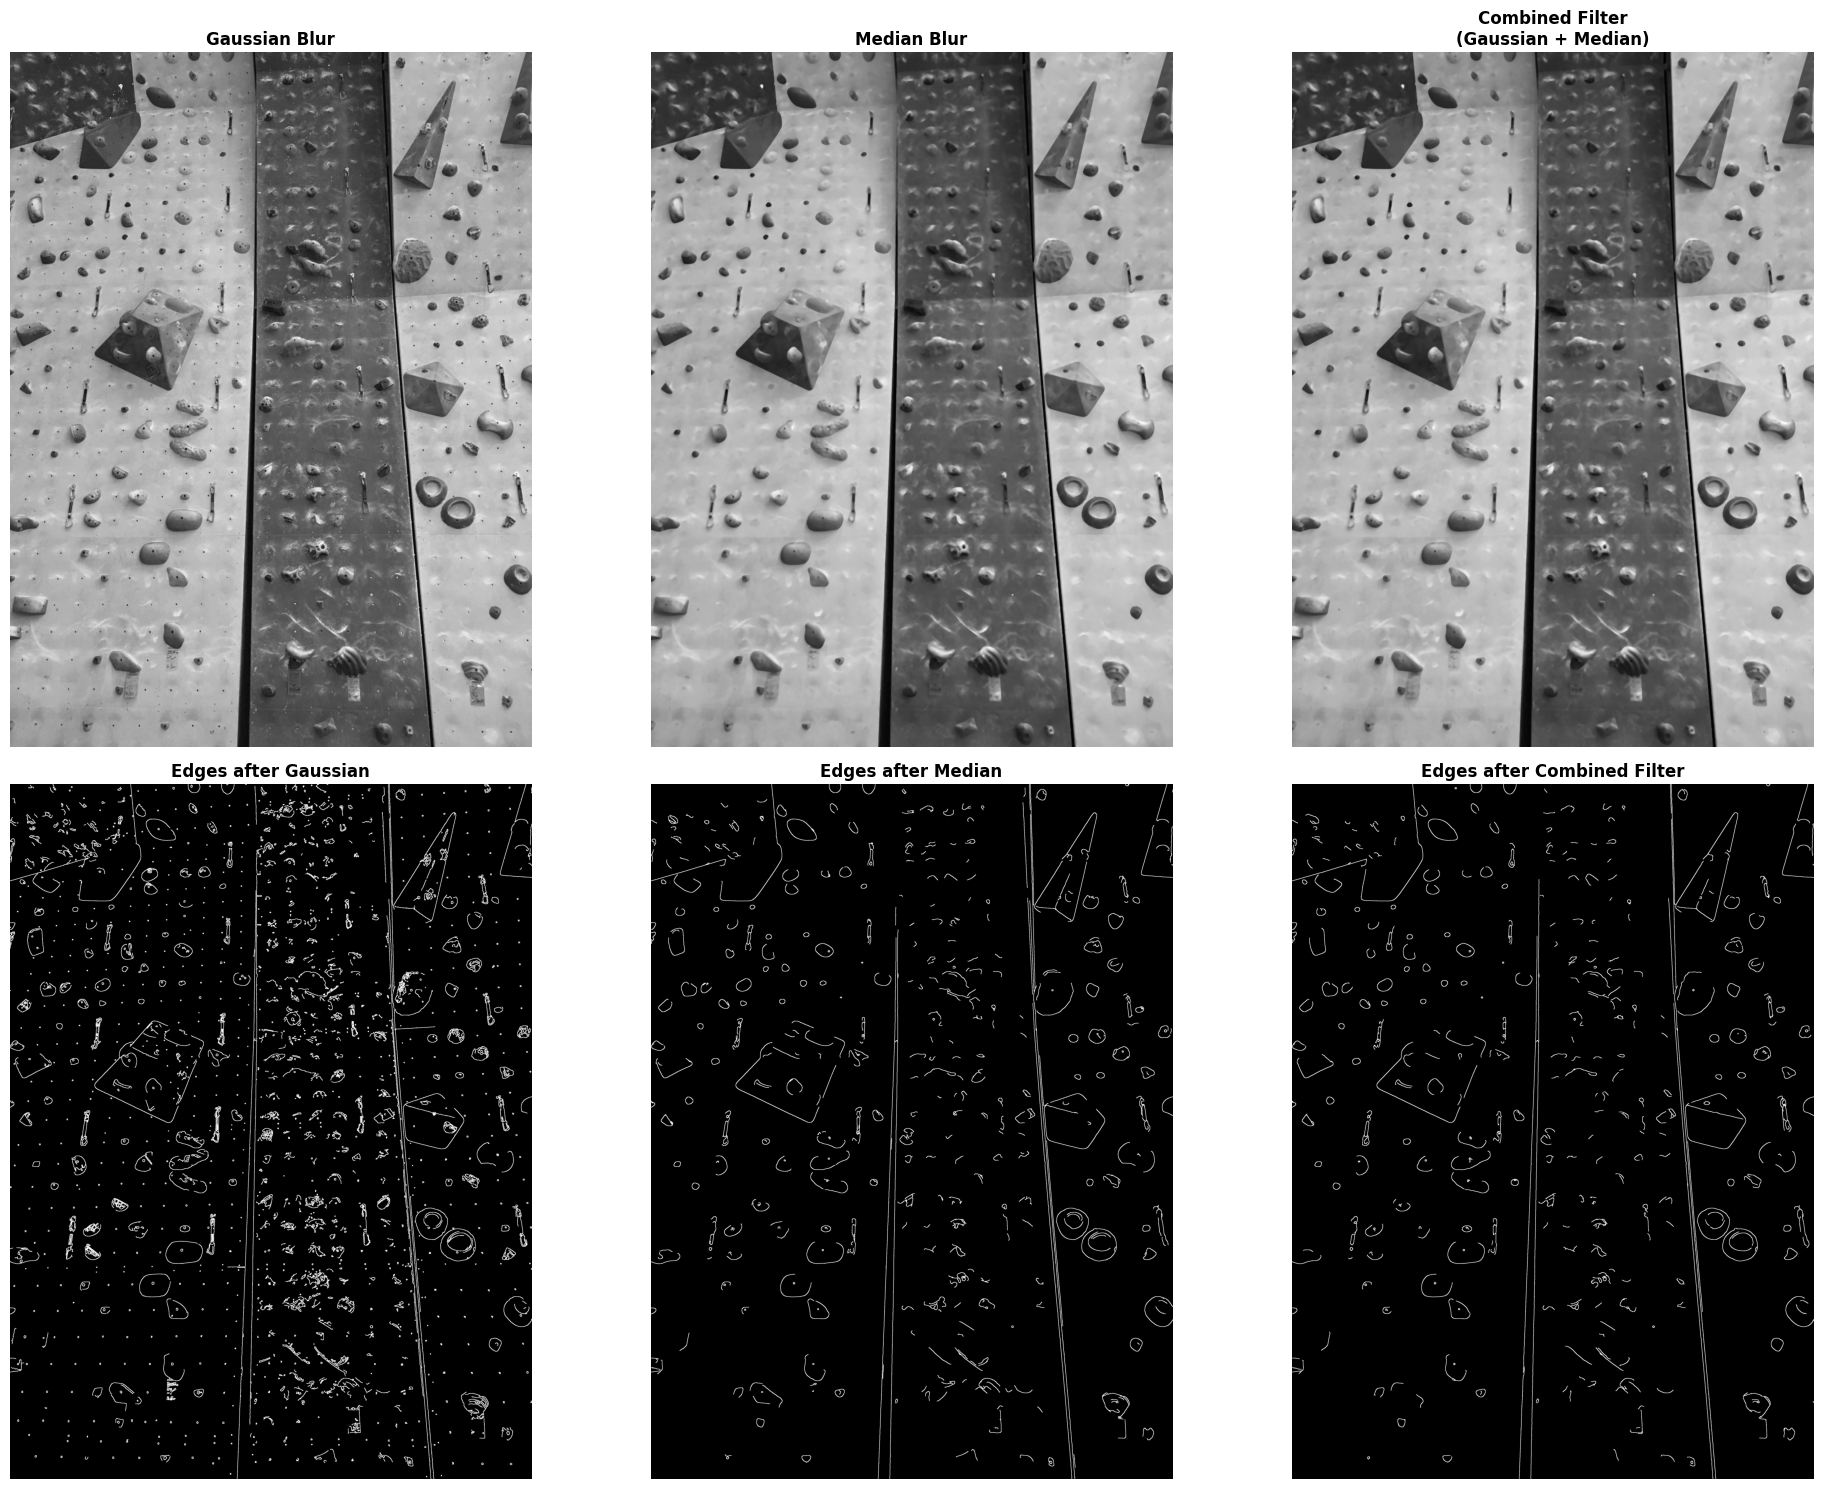

In [6]:
# Gaussian + Median Filter
def custom_combined_filter(image, gaussian_kernel=(5,5), median_kernel=15, gaussian_sigma=0):
    gaussian_result = cv2.GaussianBlur(image, gaussian_kernel, gaussian_sigma)
    final_result = cv2.medianBlur(gaussian_result, median_kernel)
    
    return final_result

# Apply filters
gaussian_blur = cv2.GaussianBlur(gray, (5,5), 0)
median_blur = cv2.medianBlur(gray, 15)
combined_blur = custom_combined_filter(gray, gaussian_kernel=(5,5), median_kernel=15, gaussian_sigma=0)

# Apply edge detection to each filtered version
canny_gaussian = process_edges_for_visualization(detect_edges(gaussian_blur, 'canny', threshold1=50, threshold2=150), thickness=2)
canny_median = process_edges_for_visualization(detect_edges(median_blur, 'canny', threshold1=50, threshold2=150), thickness=2)
canny_combined = process_edges_for_visualization(detect_edges(combined_blur, 'canny', threshold1=50, threshold2=150), thickness=2)

plt.figure(figsize=(20, 15))

# First row: Filtered images
plt.subplot(2, 3, 1)
plt.title('Gaussian Blur', fontsize=12, fontweight='bold')
plt.imshow(gaussian_blur, cmap='gray')
plt.axis('off')

plt.subplot(2, 3, 2)
plt.title('Median Blur', fontsize=12, fontweight='bold')
plt.imshow(median_blur, cmap='gray')
plt.axis('off')

plt.subplot(2, 3, 3)
plt.title('Combined Filter\n(Gaussian + Median)', fontsize=12, fontweight='bold')
plt.imshow(combined_blur, cmap='gray')
plt.axis('off')

# Second row: Edge detection results
plt.subplot(2, 3, 4)
plt.title('Edges after Gaussian', fontsize=12, fontweight='bold')
plt.imshow(canny_gaussian, cmap='gray')
plt.axis('off')

plt.subplot(2, 3, 5)
plt.title('Edges after Median', fontsize=12, fontweight='bold')
plt.imshow(canny_median, cmap='gray')
plt.axis('off')

plt.subplot(2, 3, 6)
plt.title('Edges after Combined Filter', fontsize=12, fontweight='bold')
plt.imshow(canny_combined, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()

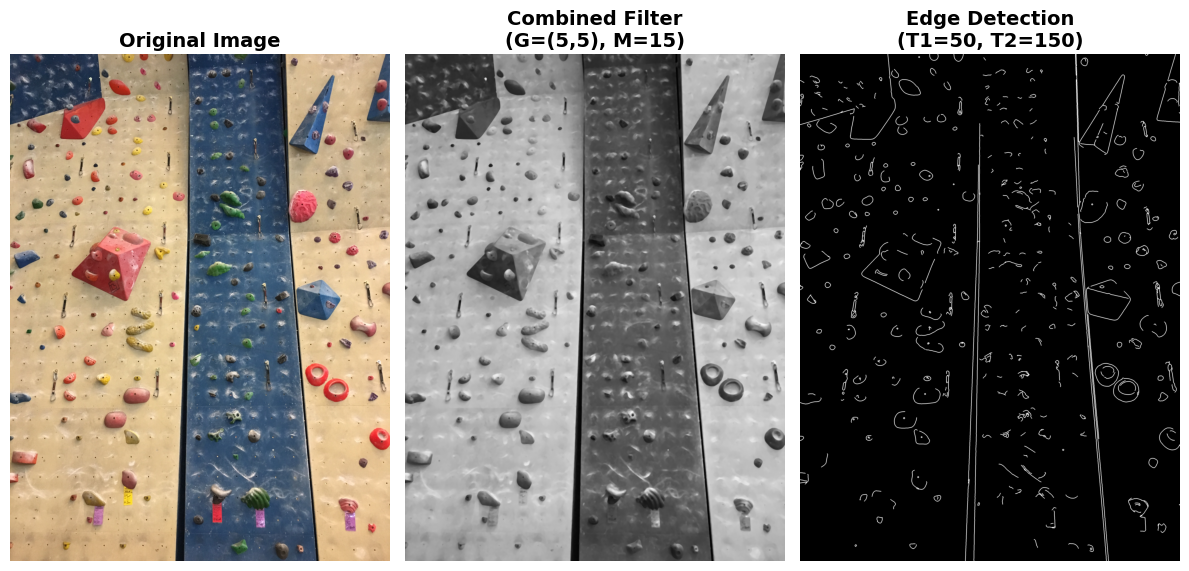

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Apply combined filter
filtered = custom_combined_filter(
    gray, 
    gaussian_kernel=(5,5),
    median_kernel=15
)

# edge detection on resulting image of combined filter
edges = process_edges_for_visualization(cv2.Canny(filtered, 50, 150), thickness=3)

# subplots
plt.subplot(131)
plt.imshow(img, cmap='gray')
plt.title('Original Image', fontsize=14, fontweight='bold')
plt.axis('off')

plt.subplot(132)
plt.imshow(filtered, cmap='gray')
plt.title(f'Combined Filter\n(G=(5,5), M=15)', fontsize=14, fontweight='bold')
plt.axis('off')

plt.subplot(133)
plt.imshow(edges, cmap='gray')
plt.title(f'Edge Detection\n(T1=50, T2=150)', fontsize=14, fontweight='bold')
plt.axis('off')

plt.tight_layout()


### Image Preprocessing summary

The preprocessing stage focused on noise reduction while preserving critical edge information for hold detection. After comparing different filtering approaches:

- **Combined Gaussian and Median Filter**: Selected as optimal solution
  - Gaussian filter (5x5) reduces initial noise and smooths image
  - Median filter (15x15) removes (some) remaining chalk marks and unwanted spots
  - Two-stage approach preserves hold edges better than single filter
  - Large median kernel handles substantial noise patches

- **Alternative Approaches**:
  - Median filter only: Less effective at preserving edges
  - Gaussian blur only: Caused excessive edge softening
  - Smaller kernels: Insufficient for larger noise areas

While the combined filtering approach produced cleaner images with better edge preservation, some challenges remain:

- **Residual Chalk Noise**: White chalk marks on holds still create bright spots that:
  - Introduce false edges within holds
  - Make it difficult to detect complete hold boundaries
  - Result in fragmented or missed hold detections

#### The next preprocessing step will focus specifically on reducing the impact of remaining chalk marks to improve hold detection accuracy.

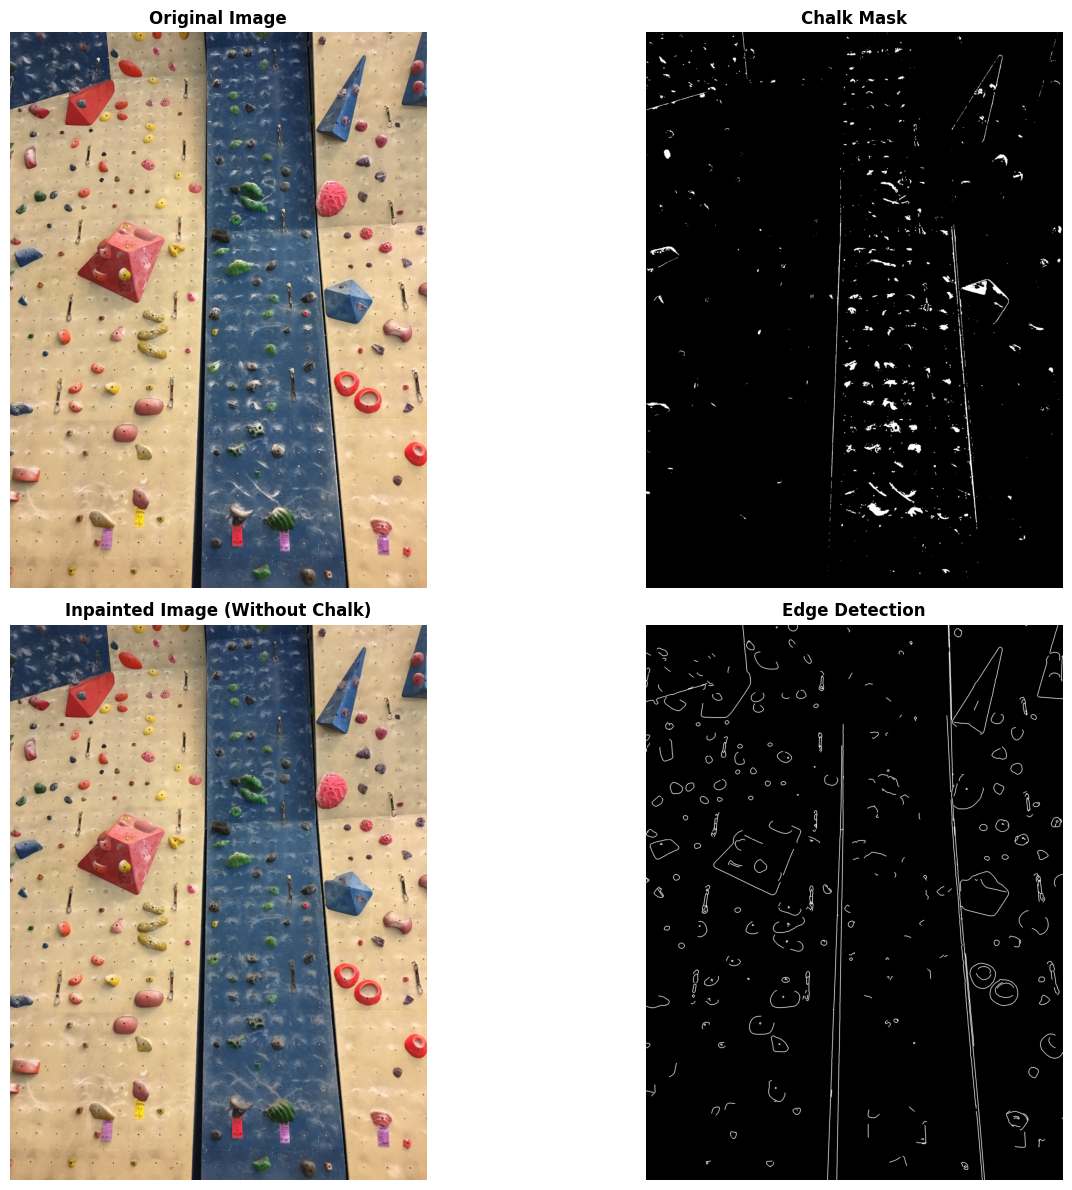

In [8]:
def preprocess_climbing_wall_with_inpainting(image):
    hsv_img = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    
    # Adjust HSV range for chalk (white/light colors)
    lower_bound = np.array([0, 0, 160])  
    upper_bound = np.array([180, 50, 255])  
    
    # Create mask for chalk
    chalk_mask = cv2.inRange(hsv_img, lower_bound, upper_bound)
    
    # Apply morphological operations to refine the mask
    kernel = np.ones((3, 3), np.uint8)
    chalk_mask = cv2.dilate(chalk_mask, kernel, iterations=1)
    
    # Use inpainting to replace chalk with surrounding colors
    inpainted_img = cv2.inpaint(image, chalk_mask, inpaintRadius=3, flags=cv2.INPAINT_TELEA)
    
    return inpainted_img, chalk_mask

plt.figure(figsize=(15, 12))

# Process the image
inpainted_img, chalk_mask = preprocess_climbing_wall_with_inpainting(img)

# Convert to grayscale for edge detection
gray_no_chalk = cv2.cvtColor(inpainted_img, cv2.COLOR_RGB2GRAY)

# Apply combined filter
filtered = custom_combined_filter(
    gray_no_chalk, 
    gaussian_kernel=(5,5),
    median_kernel=15
)

# Apply edge detection
edges = process_edges_for_visualization(cv2.Canny(filtered, 50, 150), thickness=3)

# Create subplots
plt.subplot(221)
plt.imshow(img)
plt.title('Original Image', fontsize=12, fontweight='bold')
plt.axis('off')

plt.subplot(222)
plt.imshow(chalk_mask, cmap='gray')
plt.title('Chalk Mask', fontsize=12, fontweight='bold')
plt.axis('off')

plt.subplot(223)
plt.imshow(inpainted_img)
plt.title('Inpainted Image (Without Chalk)', fontsize=12, fontweight='bold')
plt.axis('off')

plt.subplot(224)
plt.imshow(edges, cmap='gray')
plt.title('Edge Detection', fontsize=12, fontweight='bold')
plt.axis('off')

plt.tight_layout()

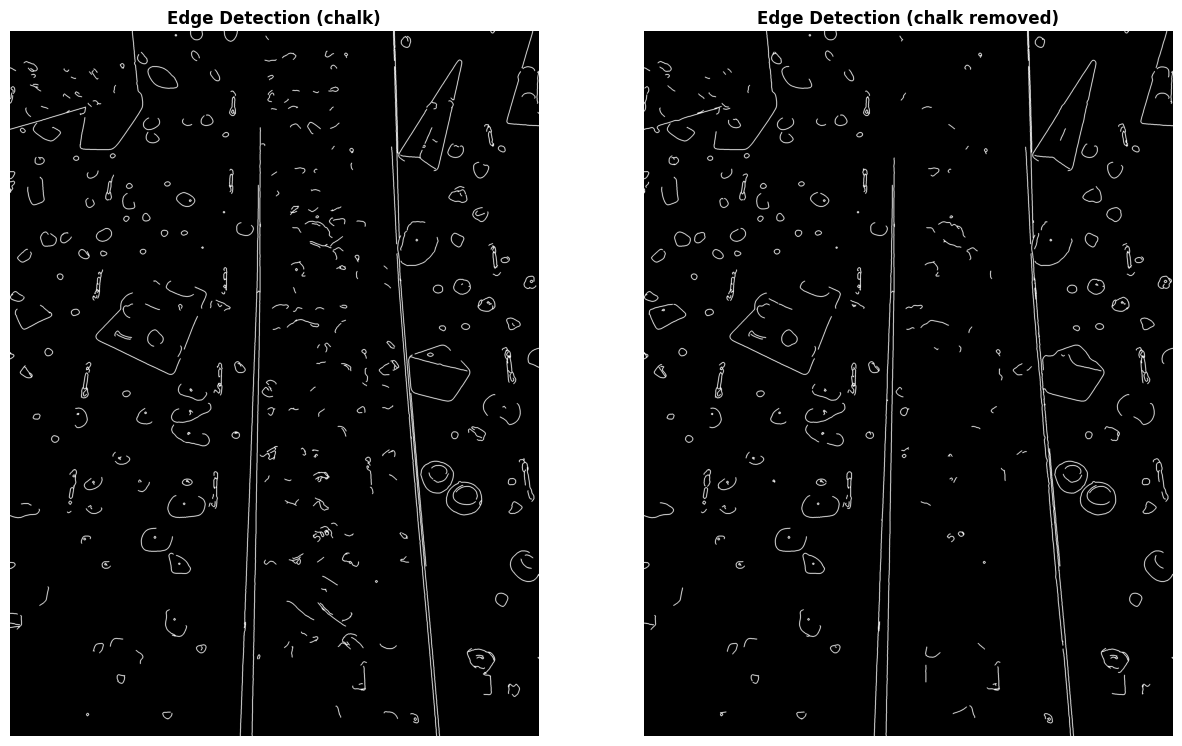

In [9]:
plt.figure(figsize=(15, 12))

# Apply combined filter
filtered_with_chalk = custom_combined_filter(
    gray, 
    gaussian_kernel=(5,5),
    median_kernel=15
)

# Apply edge detection
edges_with_chalk = process_edges_for_visualization(cv2.Canny(filtered_with_chalk, 50, 150), thickness=3)
edges_no_chalk = process_edges_for_visualization(cv2.Canny(filtered, 50, 150), thickness=3)


plt.subplot(1,2,1)
plt.imshow(edges_with_chalk, cmap='gray')
plt.title('Edge Detection (chalk)', fontsize=12, fontweight='bold')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(edges_no_chalk, cmap='gray')
plt.title('Edge Detection (chalk removed)', fontsize=12, fontweight='bold')
plt.axis('off')
plt.show()

### Chalk Removal Processing Summary

The chalk removal stage uses HSV color thresholding and inpainting to reduce noise from chalk marks. Key findings:

- **Chalk Detection and Removal**:
  - Detects chalk using HSV thresholds (Value > 150, Saturation < 60)
  - Applies morphological dilation to refine the chalk mask
  - Uses Telea inpainting algorithm with 3px radius to fill chalk regions
  - Preserves underlying wall and hold textures

- **Preprocessing Pipeline**:
  - Creates binary mask of chalk regions using color thresholds
  - Performs inpainting to reconstruct chalk areas from surrounding pixels
  - Applies Gaussian (7x7) and median (15x15) filtering before edge detection

- **Impact on Edge Detection**:
  - Significantly reduces spurious edges from chalk marks
  - Maintains key hold boundaries and features
  - Produces cleaner Canny edge maps (thresholds 50-150)

The combined approach of HSV-based chalk detection and inpainting shows good results in reducing chalk noise while preserving important climbing hold features.
